In [3]:

## Loading the dataset


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
import warnings
import os


In [4]:
import pandas as pd
import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Loading all weather CSV files
csv_files = glob.glob("/Users/michellenyashakuzakwawo/Desktop/Group Project /Deliverable 5 /Model/raw_sampled_files")

In [5]:

import pandas as pd
import glob
import os

# Locating all CSV files used for the random forest model 
csv_files = glob.glob('raw_sampled_files/*.csv')

print(f"Found {len(csv_files)} raw files to clean...")


for input_file in csv_files:
    
    output_file = input_file.replace("raw_sampled_files", "fixed_sampled_files")
    
    
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    
    with open(input_file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        
        line = line.replace('"', '').replace("'", "")
        
        line = line.rstrip(",\n") + "\n"
        cleaned_lines.append(line)

    
    with open(output_file, "w", encoding="utf-8") as f:
        f.writelines(cleaned_lines)

print("All files cleaned and saved to 'fixed_sampled_files' folder.")

#Loading all cleaned CSVs into pandas DataFrames
fixed_sampled_files = glob.glob('fixed_sampled_files/*.csv')

df_list = []
for file in fixed_sampled_files:
    try:
        df = pd.read_csv(file)
        df_list.append(df)
    except Exception as e:
        print(f"Skipped {file}: {e}")

print(f"Loaded {len(df_list)} cleaned files successfully.")

#Combining them into one DataFrame
merged_df = pd.concat(df_list, ignore_index=True)
print("Merged shape:", merged_df.shape)

#Save merged file for future use
merged_df.to_csv("merged_clean.csv", index=False)
print("Final merged CSV saved as 'merged_clean.csv'")


Found 60 raw files to clean...
✅ All files cleaned and saved to 'fixed_sampled_files' folder.
✅ Loaded 61 cleaned files successfully.
Merged shape: (2331432, 10)
✅ Final merged CSV saved as 'merged_clean.csv'


In [5]:
merged_df.head()



,Date,Longitude,Latitude,Elevation,Max Temperature,Min Temperature,Precipitation,Wind,Relative Humidity,Solar
0,1/1/1979,47.5,11.0841,249.0,27.544,17.520,0.0,4.529862,0.645346,22.372707
1,1/2/1979,47.5,11.0841,249.0,27.269,17.763,0.0,5.471283,0.627570,22.759201
2,1/3/1979,47.5,11.0841,249.0,27.799,17.475,0.0,5.819288,0.620776,22.783559
3,1/4/1979,47.5,11.0841,249.0,26.595,17.925,0.0,6.310501,0.601578,22.928408
4,1/5/1979,47.5,11.0841,249.0,26.400,17.629,0.0,6.102810,0.617669,22.454606


In [6]:

merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331432 entries, 0 to 2331431
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date               object 
 1   Longitude          float64
 2   Latitude           float64
 3   Elevation          float64
 4   Max Temperature    float64
 5   Min Temperature    float64
 6   Precipitation      float64
 7   Wind               float64
 8   Relative Humidity  float64
 9   Solar              float64
dtypes: float64(9), object(1)
memory usage: 177.9+ MB


Dataset size after cleaning: 777084 records.

Last 5 rows of features (targets excluded):
             Longitude   Latitude  Elevation      PRCP      Wind  Humidity  \
Date                                                                         
2014-12-07   50.625000  68.222000       70.0  1.086617  4.084101  0.873223   
2014-12-07   56.875000  68.222000       27.0  1.460838  4.991030  0.823907   
2014-12-07 -122.811996  69.470901      152.0  0.102997  7.885782  0.446289   
2014-12-07  -33.125000  81.959999      730.0  0.739861  2.352470  0.933024   
2014-12-07   25.625000   9.522980      655.0  0.583649  1.994458  0.791459   

                Solar           STATION  PRCP_LAG1  MONTH  DAY_OF_YEAR  
Date                                                                    
2014-12-07   8.098016     68.222_50.625   0.000000     12          341  
2014-12-07   3.968818     68.222_56.875   0.048065     12          341  
2014-12-07  15.932902  69.4709_-122.812   0.000000     12          341 

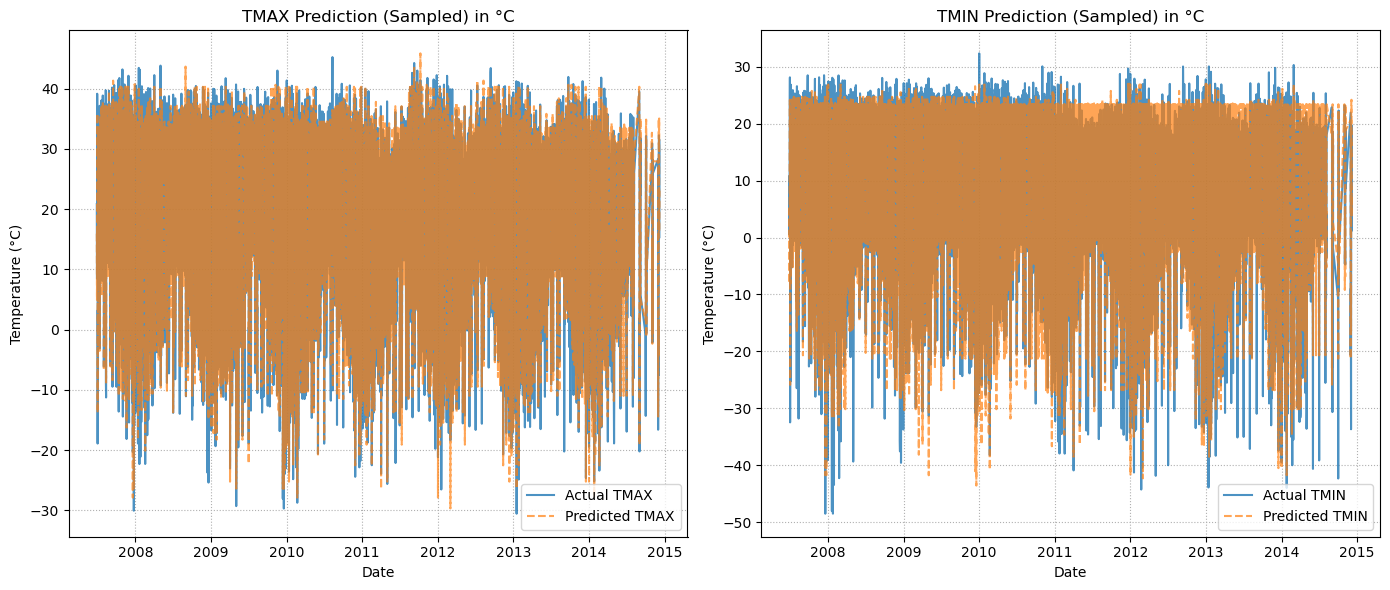

In [8]:

import warnings, re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

MERGED_PATH = "merged_clean.csv"   

data = pd.read_csv(MERGED_PATH)

RENAME_MAP = {
    "Max Temperature": "TMAX",
    "Min Temperature": "TMIN",
    "Precipitation": "PRCP",
    "Relative Humidity": "Humidity",
}

data.columns = [re.sub(r"\s+", " ", c.strip().strip('"').replace("\t"," ")) for c in data.columns]
data = data.rename(columns=RENAME_MAP)

required_cols = ['Date','Longitude','Latitude','Elevation','TMAX','TMIN','PRCP','Wind','Humidity','Solar']
missing = [c for c in required_cols if c not in data.columns]
if missing:
    raise ValueError(f"Missing required columns in {MERGED_PATH}: {missing}")


date_s = data['Date'].astype(str).str.strip()
parsed = pd.to_datetime(date_s, errors='coerce', format='%Y-%m-%d')
m = parsed.isna()
if m.any(): parsed.loc[m] = pd.to_datetime(date_s[m], errors='coerce', format='%d/%m/%Y'); m = parsed.isna()
if m.any(): parsed.loc[m] = pd.to_datetime(date_s[m], errors='coerce', format='%m/%d/%Y'); m = parsed.isna()
if m.any(): parsed.loc[m] = pd.to_datetime(date_s[m], errors='coerce')  # flexible fallback

data['Date'] = parsed

data = data.dropna(subset=['Date','TMAX','TMIN']).copy()
data = data.sort_values('Date').set_index('Date')



for col in ['Longitude','Latitude','Elevation','TMAX','TMIN','PRCP','Wind','Humidity','Solar']:
    data[col] = pd.to_numeric(data[col], errors='coerce')


data['Elevation'] = data['Elevation'].replace(-9999, np.nan)



data['STATION'] = data['Latitude'].round(4).astype(str) + "_" + data['Longitude'].round(4).astype(str)


data = data.reset_index()   

data = data.sort_values(['STATION', 'Date'], kind='stable')
data['PRCP_LAG1'] = data.groupby('STATION', sort=False)['PRCP'].shift(1)

data['Elevation'] = data.groupby('STATION', sort=False)['Elevation'].transform(lambda s: s.fillna(s.median()))
data['Elevation'] = data['Elevation'].fillna(data['Elevation'].median())


data = data.drop_duplicates(subset=['STATION','Date'], keep='first')

data = data.set_index('Date').sort_index(kind='stable')



data = data.ffill()
data = data.dropna(subset=[
    'PRCP_LAG1','TMAX','TMIN','Longitude','Latitude','Elevation','PRCP','Wind','Humidity','Solar'
])

data['MONTH'] = data.index.month
data['DAY_OF_YEAR'] = data.index.dayofyear

print(f"Dataset size after cleaning: {len(data)} records.\n")
print("Last 5 rows of features (targets excluded):")
print(data[[c for c in data.columns if c not in ['TMAX','TMIN']]].tail())


#Feature/Target matrices & chronological split (80/20)

FEATURE_COLUMNS = [
    'MONTH','DAY_OF_YEAR','Longitude','Latitude','Elevation',
    'PRCP','Wind','Humidity','Solar','PRCP_LAG1'
]
TARGET_COLUMNS = ['TMAX','TMIN']

X = data[FEATURE_COLUMNS]
Y_MULTI = data[TARGET_COLUMNS]
Y_TMAX_CLASSIFICATION = data['TMAX']  

split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
Y_train_multi, Y_test_multi = Y_MULTI.iloc[:split_point], Y_MULTI.iloc[split_point:]
Y_train_cls,  Y_test_cls  = Y_TMAX_CLASSIFICATION.iloc[:split_point], Y_TMAX_CLASSIFICATION.iloc[split_point:]

print(f"\nTrain Set Size: {len(X_train)} records")
print(f"Test Set Size:  {len(X_test)} records")


# Building Base Model Multi-Output Regression (Decision Tree)

print("\n" + "="*70)
print("V. Multi-Output Regression: Predicting TMAX and TMIN in °C")
print("="*70)

base_dtr = DecisionTreeRegressor(max_depth=12, random_state=42)
multi_target_dtr = MultiOutputRegressor(base_dtr)

multi_target_dtr.fit(X_train, Y_train_multi)

Y_pred_multi = multi_target_dtr.predict(X_test)
Y_pred_df = pd.DataFrame(Y_pred_multi, index=Y_test_multi.index, columns=TARGET_COLUMNS)

# Metrics
mae_max = mean_absolute_error(Y_test_multi['TMAX'], Y_pred_df['TMAX'])
rmse_max = np.sqrt(mean_squared_error(Y_test_multi['TMAX'], Y_pred_df['TMAX']))
mae_min = mean_absolute_error(Y_test_multi['TMIN'], Y_pred_df['TMIN'])
rmse_min = np.sqrt(mean_squared_error(Y_test_multi['TMIN'], Y_pred_df['TMIN']))

print("Decision Tree Multi-Output Regressor Performance on Test Set:")
print(f" - TMAX MAE: {mae_max:.2f} °C | RMSE: {rmse_max:.2f} °C")
print(f" - TMIN MAE: {mae_min:.2f} °C | RMSE: {rmse_min:.2f} °C")


# Plots (simple line plots, sampled for clarity)

plt.figure(figsize=(14, 6))

# TMAX
plt.subplot(1, 2, 1)
plt.plot(Y_test_multi.index[::50], Y_test_multi['TMAX'].values[::50], label='Actual TMAX', alpha=0.8)
plt.plot(Y_pred_df.index[::50],   Y_pred_df['TMAX'].values[::50],   label='Predicted TMAX', alpha=0.7, linestyle='--')
plt.title('TMAX Prediction (Sampled) in °C')
plt.xlabel('Date'); plt.ylabel('Temperature (°C)'); plt.legend(); plt.grid(True, linestyle=':')

# TMIN
plt.subplot(1, 2, 2)
plt.plot(Y_test_multi.index[::50], Y_test_multi['TMIN'].values[::50], label='Actual TMIN', alpha=0.8)
plt.plot(Y_pred_df.index[::50],   Y_pred_df['TMIN'].values[::50],   label='Predicted TMIN', alpha=0.7, linestyle='--')
plt.title('TMIN Prediction (Sampled) in °C')
plt.xlabel('Date'); plt.ylabel('Temperature (°C)'); plt.legend(); plt.grid(True, linestyle=':')

plt.tight_layout()
plt.show()


In [9]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, make_scorer


In [10]:

#Using same evaluation metrics as the random forest

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error (0–100%)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    smape_val = np.mean(np.divide(diff, denom, out=np.zeros_like(diff), where=denom!=0)) * 100
    return smape_val


In [11]:
print("Decision Tree Multi-Output Regressor Performance on Test Set:")
print(f" - TMAX MAE: {mae_max:.2f} °C | RMSE: {rmse_max:.2f} °C")
print(f" - TMIN MAE: {mae_min:.2f} °C | RMSE: {rmse_min:.2f} °C")


Decision Tree Multi-Output Regressor Performance on Test Set:
 - TMAX MAE: 3.22 °C | RMSE: 4.56 °C
 - TMIN MAE: 3.36 °C | RMSE: 4.79 °C


In [12]:

# R²
r2_max = r2_score(Y_test_multi['TMAX'], Y_pred_df['TMAX'])
r2_min = r2_score(Y_test_multi['TMIN'], Y_pred_df['TMIN'])

# SMAPE
smape_max = smape(Y_test_multi['TMAX'], Y_pred_df['TMAX'])
smape_min = smape(Y_test_multi['TMIN'], Y_pred_df['TMIN'])

print(f" - TMAX R²: {r2_max:.3f} | SMAPE: {smape_max:.2f}%")
print(f" - TMIN R²: {r2_min:.3f} | SMAPE: {smape_min:.2f}%")


 - TMAX R²: 0.916 | SMAPE: 29.95%
 - TMIN R²: 0.884 | SMAPE: 41.32%


In [15]:
#Cross Validation
kf = KFold(n_splits=5, shuffle=False)  
cv_scores = cross_val_score(multi_target_dtr, X_train, Y_train_multi, cv=kf, scoring='r2')

print("Cross-validation R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))


Cross-validation R² scores: [0.91007511 0.91013525 0.91002406 0.9095203  0.90834232]
Mean CV R²: 0.9096194076044238
